In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [2]:
data_path = "../data/upps_total.csv"
data = pd.read_csv(data_path)

In [3]:
def create_splits(df:pd.DataFrame):
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.15, 
        random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, 
        y_train,
        test_size=X_test.shape[0] / X_train.shape[0],  
        random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = create_splits(data)

In [5]:
def identify_variable_types(data):
    continuous_vars = []
    dummy_vars = []

    num_columns = data.shape[1]
    
    for i in range(num_columns):
        unique_values = np.unique(data[:, i])
        if len(unique_values) == 2 and np.array_equal(unique_values, [0, 1]):
            dummy_vars.append(i)
        else:
            continuous_vars.append(i)
    
    return continuous_vars, dummy_vars

In [6]:
def transform_X(X_train, X_val, X_test):

    continuous_cols, dummy_cols = identify_variable_types(X_train)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_cols),
            ('dummy', 'passthrough', dummy_cols)  # Leave dummy variables unchanged or use StandardScaler() if needed
        ]
    )
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)

    return X_train, X_val, X_test

In [7]:
X_train, X_val, X_test = transform_X(X_train, X_val, X_test)

In [8]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [9]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [10]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    model_performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': round(performance, 4),
                         'r2': round(r2, 4)})

In [11]:
model_performances = []

In [12]:
evaluate(model=None, model_name='dummy', constant_value=y_train.mean())

In [13]:
reg = LinearRegression().fit(X_train, y_train)
evaluate(model=reg, model_name='linear')

In [14]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        evaluate(model=reg, model_name=f'{id}-alpha-{alpha}')

In [15]:
def _compute_bias(pred, true):
    ''' Function to compute bias. 
        Note that here we compute the average squared bias of the model
        over all data points to get a sense for its tendency to make 
        systematically "off-target" predictions.

    Args:
        pred (np.array): array of shape (n_samples, n_bootstrap), where n_samples is the size
            of the test set, and n_bootstraps is how many times we sample data from the training
            set and fit our model
        true (np.array): predictions of the true model. It is an array of shape (n_samples)
    '''
    mpred = pred.mean(axis=1)
    return (((true - mpred)**2)).mean()

In [16]:
def _compute_variance(pred):
    ''' Function to compute variance
    Args:
        pred (np.array): array of shape (n_samples, n_bootstrap), where n_samples is the size
            of the test set, and n_bootstraps is how many times we sample data from the training
            set and fit our model
    '''
    return pred.var(axis=1).mean()

In [17]:
# run random forest regression
rfreg = RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9], 
    'ccp_alpha': [0.01, 0.1, 1.0]
}
cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=100, # this should more likely be above 100, and in general the higher the better
                            cv=5)
cv_rfr.fit(X_train, y_train)
evaluate(model=cv_rfr.best_estimator_, model_name=f'random-forest')

In [18]:
# run xgboost regression
xgbreg = XGBRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'objective': ['reg:squarederror'],
    'colsample_bytree': [0.3, 0.6, 0.9],
    'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
}
cv_xgb = RandomizedSearchCV(estimator=xgbreg, 
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error',
                            n_iter=100, # this should be at least 100
                            cv=5)
cv_xgb.fit(X_train, y_train)
evaluate(model=cv_xgb.best_estimator_, model_name=f'xgboost')

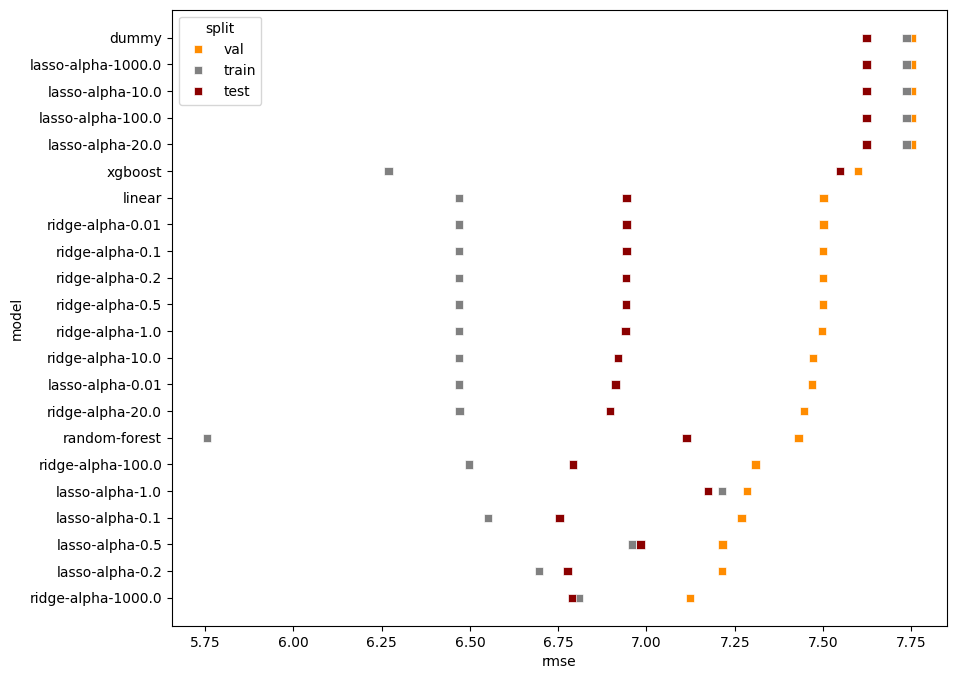

In [19]:
perf_df = pd.DataFrame(model_performances)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=perf_df.sort_values(
        by='rmse', 
        ascending=False), 
    y='model', 
    x='rmse', 
    marker='s', 
    hue='split', 
    palette=['darkorange', 'grey', 'darkred'])
plt.show()